<a href="https://colab.research.google.com/github/Chygos/competitions/blob/main/nfts/data_cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# __Description__

Non-Fungible Tokens (NFTs) have become not only one of the most popular ways for creators to sell their artistic content worldwide, but also a common investment vehicle in general. A prestigious brokerage for modern and contemporary art wants to move deeper into the digital space, and believes that NFT investments will become even more popular as the number of them proliferates in the market, despite the economic headwind likely to emerge in the near future. 

That said, it's a common notion that NFT pricing is largely driven by speculation rather than an underlying value such as earnings or future cashflow in traditional investments (e.g. stocks, real estate). This unique characteristic is one of the challenges for the art brokerage in choosing the right NFTs to feature in their auctions, leading to the question of whether the fluctuations in price follow some sort of pattern or not (think about the technical analysis on cryptocurrencies). The company would like some kind of tool to evaluate the NFTs that pique their interest. 

The goal of this competition is to build a model that predicts __the price of NFTs__ based on a select group of their attributes that are publicly accessible and also based on their social media activity.


## Approach

### Data Preprocessing
Here, we will perform some data manipulation and preprocessing to prepare data for modelling. Preprocessing steps will be to check for missing values, duplicate rows, inconsistencies in the data and then preprocess them to their appropriate state.

### Feature Engineering
Here we will create features that may be important at helping us predicting the price of an NFT. Features include
- The number of nfts in each collection at a particular month of sale
- The month and quarter of sale of that NFT
- The age of collection ID. Here we will create the age of collection when the NFT was sold and the overall age of the collection ID since creation date
- Average rate of change of average price per month
- Cluster the twitter data and attributes of collection ID
- The summary statistics (min, max, mean, std) of last sale price for each collection ID. Before this will be calculated, new collection IDs will be assigned the values for the cluster they are assigned to.
- Fit a classification model to predict the probability that a particular NFT, based on information about it and the colleciton it belongs to, will be sold at a price above the mean value of NFT sales. The probability will be used as a feature to predict the price it will be sold.


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
# changing directory
import os
os.chdir("./gdrive/My Drive/bitgrid competitions/NFT_price_prediction/")

In [ ]:
!pip install scikit-learn lightgbm -U --q

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import sklearn
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [ ]:
sklearn.__version__, lgb.__version__

('1.2.0', '3.3.4')

In [ ]:
train = pd.read_csv('data/nfts_train.csv', parse_dates=['last_sale_date'])
test = pd.read_csv('data/nfts_predict.csv', parse_dates=['last_sale_date'])
collections = pd.read_csv('data/collections.csv', parse_dates=['creation_date'], index_col=0)
collections_tweet = pd.read_csv('data/collections_twitter_stats.csv', index_col=0)

In [ ]:
pd.set_option('display.max_columns', 140)

In [ ]:
train.head()

,global_index,nft_id,collection_id,rarity_score,openrarity_score,openrarity_rank,openrarity_max_rank,last_sale_date,last_sale_price
0,21928,0,49,2.000000,NaN,NaN,NaN,2022-11-01,1.266732
1,32621,0,45,97.077216,NaN,NaN,NaN,2021-08-01,1.200357
2,32622,1,45,139.453086,NaN,NaN,NaN,2022-08-01,3.180572
3,32623,2,45,127.753445,NaN,NaN,NaN,2021-08-01,3.502910
4,32624,3,45,112.315719,NaN,NaN,NaN,2022-09-01,4.009567


In [ ]:
test.head()

,global_index,nft_id,collection_id,rarity_score,openrarity_score,openrarity_rank,openrarity_max_rank,last_sale_date
0,0,0,29,176.364208,NaN,NaN,NaN,2022-06-01
1,1,1,29,207.209228,NaN,NaN,NaN,2022-05-01
2,2,2,29,157.293414,NaN,NaN,NaN,2022-10-01
3,3,3,29,173.372185,NaN,NaN,NaN,2022-06-01
4,4,4,29,190.077584,NaN,NaN,NaN,2022-06-01


In [ ]:
collections.head()

,collection_id,total_supply,creation_date,verification_status,n_of_traits,contract_type,seller_fees,platform_fees,openrarity_enabled,has_website,has_own_twitter,has_discord,has_medium
0,19,1000,2021-04-01,verified,4,own,500.0,250,False,False,True,True,True
1,45,8888,2021-07-01,verified,5,own,500.0,250,False,False,True,True,False
2,44,10000,2022-04-01,verified,8,own,500.0,250,True,False,True,True,False
3,53,9999,2022-07-01,verified,9,own,900.0,250,False,False,True,True,False
4,6,9602,2021-06-01,verified,8,own,NaN,250,False,False,True,True,False


In [ ]:
collections_tweet.head()

,collection_id,n_tweets_in_range,avg_likes,avg_replies,avg_retweets,min_likes,min_replies,min_retweets,max_likes,max_replies,max_retweets
0,0,2,183.000000,8.500000,41.000000,123,3,6,243,14,76
1,1,16,36.375000,3.562500,13.937500,0,0,0,125,21,34
2,2,1,15.000000,9.000000,1.000000,15,9,1,15,9,1
3,3,526,1.178707,0.306084,2.655894,0,0,0,21,8,13
4,4,26,8.153846,0.884615,1.153846,0,0,0,30,6,12


### Data Manipulation and Preprocessing

In [ ]:
collections.shape, collections_tweet.shape, train.shape, test.shape

((48, 13), (48, 11), (309910, 9), (181214, 8))

In [ ]:
# number of nfts sold and number of collections
pd.concat([train, test]).nft_id.nunique(), pd.concat([train, test]).collection_id.nunique()

(48257, 48)

In [ ]:
# if there are duplicate rows
collections.drop_duplicates().shape[0] != collections.shape[0]

False

In [ ]:
# missing values
train.isna().any().sum(), test.isna().any().sum()

(3, 3)

In [ ]:
missing = pd.concat([train, test]).isna().sum()
missing[missing > 0]

openrarity_score       372018
openrarity_rank        372018
openrarity_max_rank    372018
last_sale_price        181214
dtype: int64

In [ ]:
collections = collections.sort_values('collection_id').reset_index(drop=True)

In [ ]:
missing = pd.concat([collections, collections_tweet], axis=1).isna().sum()
missing[missing > 0]

seller_fees    2
dtype: int64

In [ ]:
collections.head()

,collection_id,total_supply,creation_date,verification_status,n_of_traits,contract_type,seller_fees,platform_fees,openrarity_enabled,has_website,has_own_twitter,has_discord,has_medium
0,0,6501,2022-04-01,verified,31,own,500.0,250,False,False,True,True,True
1,1,15000,2022-04-01,verified,12,own,500.0,250,True,False,True,True,False
2,2,20279,2021-07-01,approved,7,default,200.0,250,False,False,True,False,False
3,3,9124,2021-01-01,approved,26,default,1000.0,250,False,False,True,True,True
4,4,9000,2022-02-01,approved,8,default,900.0,250,False,False,True,False,False


In [ ]:
collections.select_dtypes('number').nunique()

collection_id    48
total_supply     38
n_of_traits      22
seller_fees       9
platform_fees     1
dtype: int64

In [ ]:
collections.select_dtypes(['object', 'bool']).nunique()

verification_status    2
contract_type          2
openrarity_enabled     2
has_website            1
has_own_twitter        1
has_discord            2
has_medium             2
dtype: int64

- For both the train and test sets, there are three variables with missing values. They include open_rarity score, rank and max_rank. The missing value in last_sale_price is as a result of joining the train and test sets along the columns since the test set doesn't have such feature name
- For collections or their tweet data, only 2 IDs do not have seller fees
- There are three features (platform_fees, has_website and has_own_twitter) in collections data with one unique value. We will drop them since they won't be adding any info to our data

In [ ]:
cat_cols = collections.select_dtypes(['object', 'bool']).columns
for col in cat_cols:
  print(f'{col}: {collections[col].unique()}')

verification_status: ['verified' 'approved']
contract_type: ['own' 'default']
openrarity_enabled: [False  True]
has_website: [False]
has_own_twitter: [ True]
has_discord: [ True False]
has_medium: [ True False]


In [ ]:
# dropping has_website and has_own_twitter
collections = collections.drop(columns=['platform_fees', 'has_website', 'has_own_twitter'])

In [ ]:
# removing from categorical variables
cat_cols = cat_cols.drop(['has_website', 'has_own_twitter'])

In [ ]:
# replacing categorical features with  binary numbers
collections = collections.replace(['verified', 'own', True], 1).replace(['approved', 'default', False], 0)

In [ ]:
collections.head()

,collection_id,total_supply,creation_date,verification_status,n_of_traits,contract_type,seller_fees,openrarity_enabled,has_discord,has_medium
0,0,6501,2022-04-01,1,31,1,500.0,0,1,1
1,1,15000,2022-04-01,1,12,1,500.0,1,1,0
2,2,20279,2021-07-01,0,7,0,200.0,0,0,0
3,3,9124,2021-01-01,0,26,0,1000.0,0,1,1
4,4,9000,2022-02-01,0,8,0,900.0,0,0,0


In [ ]:
# collections Age (Months since creation)
collections['age'] = (pd.to_datetime('2022-12-31') - collections.creation_date)/np.timedelta64(1,'M')

## Clustering Collection attributes

Here, we will cluster attributes of all collections. Firstly, we will merge the twitter data to the collections dataset

In [ ]:
# merging all collections data
collections = collections.merge(collections_tweet, on='collection_id', how='inner')
del collections_tweet

In [ ]:
collections.head()

,collection_id,total_supply,creation_date,verification_status,n_of_traits,contract_type,seller_fees,openrarity_enabled,has_discord,has_medium,age,n_tweets_in_range,avg_likes,avg_replies,avg_retweets,min_likes,min_replies,min_retweets,max_likes,max_replies,max_retweets
0,0,6501,2022-04-01,1,31,1,500.0,0,1,1,9.002238,2,183.000000,8.500000,41.000000,123,3,6,243,14,76
1,1,15000,2022-04-01,1,12,1,500.0,1,1,0,9.002238,16,36.375000,3.562500,13.937500,0,0,0,125,21,34
2,2,20279,2021-07-01,0,7,0,200.0,0,0,0,18.004476,1,15.000000,9.000000,1.000000,15,9,1,15,9,1
3,3,9124,2021-01-01,0,26,0,1000.0,0,1,1,23.951210,526,1.178707,0.306084,2.655894,0,0,0,21,8,13
4,4,9000,2022-02-01,0,8,0,900.0,0,0,0,10.940676,26,8.153846,0.884615,1.153846,0,0,0,30,6,12


In [ ]:
cluster_data = collections.drop(columns = ['collection_id', 'creation_date', 'seller_fees'])

In [ ]:
cluster_data.nunique()[cluster_data.nunique() == 2].index.drop(['has_medium'])

Index(['verification_status', 'contract_type', 'openrarity_enabled',
       'has_discord'],
      dtype='object')

In [ ]:
def clustering(data, n, scaler):
  kmeans = KMeans(n_clusters=n, random_state=0, max_iter=1000, n_init=10)
  return kmeans.fit(scaler.fit_transform(data))

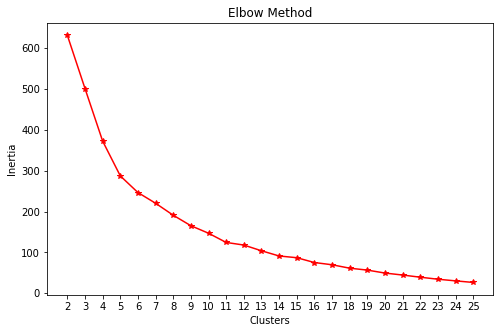

In [ ]:
scores = []
for i in range(2, 26):
  kmeans = clustering(cluster_data, n=i, scaler=StandardScaler())
  scores.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(range(2,26), scores, 'r-*')
plt.title('Elbow Method')
plt.xlabel('Clusters')
plt.ylabel('Inertia')
plt.xticks(range(2,26), range(2,26));

Grouping into 5 clusters

In [ ]:
scaled_data = MinMaxScaler().fit_transform(cluster_data)
labels = clustering(cluster_data, 3, MinMaxScaler()).predict(scaled_data)

In [ ]:
np.bincount(labels)

array([17, 13, 18])

MinMaxScaler was used as scaling method because it gave lower inertia (mean squared scores). Also, 3 clusters was used because the number of samples in each cluster was uniform (that is, almost same in number). Using higher clusters disintegrates them into clusters with smaller number of samples in them.

In [ ]:
collections['c_labels'] = labels + 1

## Feature Engineering

In [ ]:
# target variable
TARGET = 'last_sale_price'

### Merging Data

Merging collections data to train and test data. We will use a left join method, that is every collection ID in train and test will be merged from the collections data

In [ ]:
# merge collections to train and test 
train = train.merge(collections, on='collection_id', how='left')
test = test.merge(collections, on='collection_id', how='left')

In [ ]:
train.head()

,global_index,nft_id,collection_id,rarity_score,openrarity_score,openrarity_rank,openrarity_max_rank,last_sale_date,last_sale_price,total_supply,creation_date,verification_status,n_of_traits,contract_type,seller_fees,openrarity_enabled,has_discord,has_medium,age,n_tweets_in_range,avg_likes,avg_replies,avg_retweets,min_likes,min_replies,min_retweets,max_likes,max_replies,max_retweets,c_labels
0,21928,0,49,2.000000,NaN,NaN,NaN,2022-11-01,1.266732,1,2022-04-01,1,2,1,1000.0,0,1,0,9.002238,31,187.967742,8.290323,60.935484,0,0,2,591,28,380,1
1,32621,0,45,97.077216,NaN,NaN,NaN,2021-08-01,1.200357,8888,2021-07-01,1,5,1,500.0,0,1,0,18.004476,11,133.181818,13.454545,55.181818,0,0,7,402,47,239,1
2,32622,1,45,139.453086,NaN,NaN,NaN,2022-08-01,3.180572,8888,2021-07-01,1,5,1,500.0,0,1,0,18.004476,11,133.181818,13.454545,55.181818,0,0,7,402,47,239,1
3,32623,2,45,127.753445,NaN,NaN,NaN,2021-08-01,3.502910,8888,2021-07-01,1,5,1,500.0,0,1,0,18.004476,11,133.181818,13.454545,55.181818,0,0,7,402,47,239,1
4,32624,3,45,112.315719,NaN,NaN,NaN,2022-09-01,4.009567,8888,2021-07-01,1,5,1,500.0,0,1,0,18.004476,11,133.181818,13.454545,55.181818,0,0,7,402,47,239,1


In [ ]:
# collection's age at NFT sale and month of sale
train['col_age_at_sale'] = (train.last_sale_date - train.creation_date)/np.timedelta64(1,'M')
train['sale_month'] = train.last_sale_date.dt.month
train['sale_quarter'] = train.last_sale_date.dt.quarter
train['sale_year'] = train.last_sale_date.dt.year


test['col_age_at_sale'] = (test.last_sale_date - test.creation_date)/np.timedelta64(1,'M')
test['sale_month'] = test.last_sale_date.dt.month
test['sale_quarter'] = test.last_sale_date.dt.quarter
test['sale_year'] = test.last_sale_date.dt.year

In [ ]:
cluster_stat = train.groupby('c_labels')[TARGET].agg(['min', 'mean', 'max', 'std'])

collection_stat = train.groupby('collection_id')[TARGET].agg(['min', 'mean', 'max', 'std'])

cluster_stat.columns = [f'clust_targ_{i}' for i in cluster_stat.columns]
collection_stat.columns = [f'coll_targ_{i}' for i in collection_stat.columns]

In [ ]:
print(cluster_stat.head())
print()
print(collection_stat.head())

          clust_targ_min  clust_targ_mean  clust_targ_max  clust_targ_std
c_labels                                                                 
1           5.753438e-07         5.914540     1024.001504       22.541674
2           3.137229e-07         1.756618      350.006966        6.240145
3           6.485360e-08         0.007341        3.484961        0.022429

               coll_targ_min  coll_targ_mean  coll_targ_max  coll_targ_std
collection_id                                                             
0               5.753438e-07        0.319207      18.754642       0.525576
1               3.137229e-07        0.588378      40.004320       1.377267
4               2.219493e-06        0.005132       0.064771       0.003235
6               2.164313e-06        4.231422      75.008824       4.518223
7               3.981010e-06       39.836370    1024.001504      54.771641


In [ ]:
# number of NFTs sold in sale date
collection_num_nft_sdate = pd.concat([train,test]).groupby(['last_sale_date', 'collection_id']).nft_id.count()

collection_num_nft_sdate.name = 'n_nft_in_sdate'

Summary of NFTs sold in each collection that particular month
We will create the min, mean, std and max price sold for an NFT in that collection for that month

In [ ]:
# summary stat of collection_id that month/date of sale
sale_stats = (
    train.dropna(subset=[TARGET])
    .groupby(['last_sale_date', 'collection_id'])[TARGET]
    .agg(['min', 'mean', 'max', 'std'])
    )

sale_stats.columns = [f'col_{i}_last_sale_price' for i in sale_stats.columns]

## Merging engineered features into train and test

In [ ]:
test = (
    test.merge(collection_stat, on='collection_id', how='left')
    .merge(collection_num_nft_sdate, on=['collection_id', 'last_sale_date'], how='left')
    .merge(sale_stats, on=['collection_id', 'last_sale_date'], how='left')
    )

In [ ]:
train = (
    train.merge(collection_stat, on='collection_id', how='left')
    .merge(collection_num_nft_sdate, on=['collection_id', 'last_sale_date'], how='left')
    .merge(sale_stats, on=['collection_id', 'last_sale_date'], how='left')
    )

In [ ]:
train.isna().sum()[train.isna().sum() > 0]

openrarity_score           229430
openrarity_rank            229430
openrarity_max_rank        229430
seller_fees                 32693
coll_targ_std                   1
col_std_last_sale_price         4
dtype: int64

In [ ]:
test.isna().sum()[test.isna().sum() > 0]

openrarity_score            142588
openrarity_rank             142588
openrarity_max_rank         142588
coll_targ_min               181214
coll_targ_mean              181214
coll_targ_max               181214
coll_targ_std               181214
col_min_last_sale_price     181214
col_mean_last_sale_price    181214
col_max_last_sale_price     181214
col_std_last_sale_price     181214
dtype: int64

## Exploratory Data Analysis

__Number of NFTs sold till date__

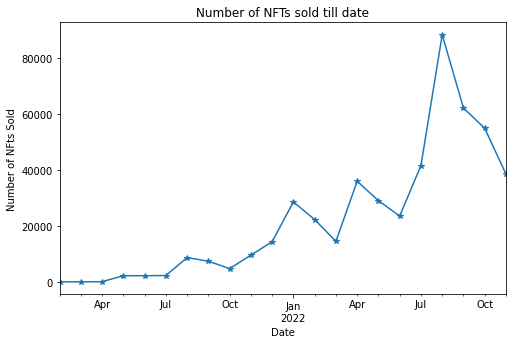

In [ ]:
# number of nft's sold
pd.concat([train, test]).groupby('last_sale_date').nft_id.count().plot(figsize=(8,5), marker='*')
plt.title('Number of NFTs sold till date')
plt.ylabel('Number of NFts Sold')
plt.xlabel('Date');

The number of NFTs sold per month has seen an increased trend until July when the number of NFTs sold has begun to decrease

__Number of NFTs sold per collection per month__

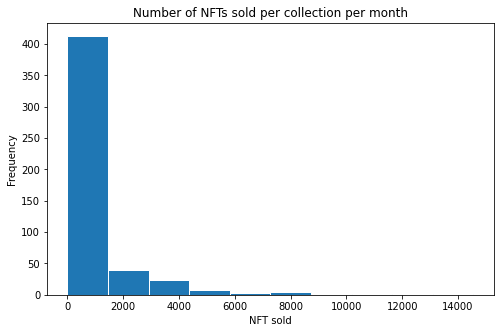

In [ ]:
# Number of NFTs in sold each collection
(
    pd.concat([train, test])
    .groupby(['last_sale_date', 'collection_id']).nft_id.count()
    .plot.hist(figsize=(8,5), edgecolor='w')
)

plt.title('Number of NFTs sold per collection per month')
plt.xlabel('NFT sold')
plt.show()

Most NFTs cold in each collection per month is less than 2000

__Distribution of the Selling Prices of NFTs__

In [ ]:
train.last_sale_price.describe()

count    3.099100e+05
mean     2.162269e+00
std      1.275132e+01
min      6.485360e-08
25%      4.077085e-03
50%      8.103344e-03
75%      3.252062e-01
max      1.024002e+03
Name: last_sale_price, dtype: float64

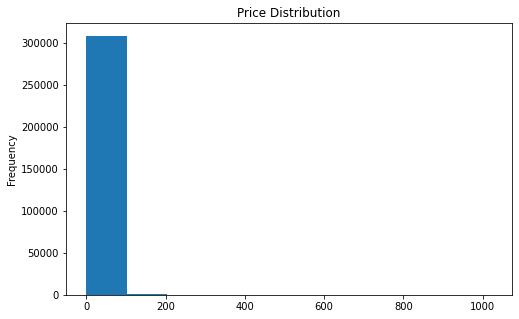

In [ ]:
# Price Distribution of NFTs sold
train[TARGET].plot.hist(figsize=(8,5))
plt.title('Price Distribution')
plt.show()

Most items were sold less than 100

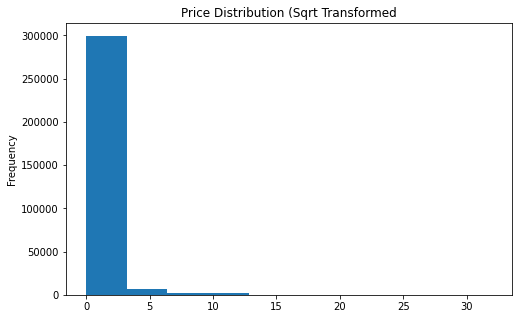

In [ ]:
# Price Distribution of NFTs sold
np.sqrt(train[TARGET]).plot.hist(figsize=(8,5))
plt.title('Price Distribution (Sqrt Transformed')
plt.show()

__Average price of NFTs sold per month__

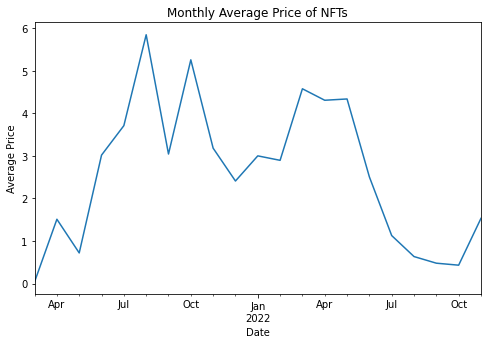

In [ ]:
train.groupby('last_sale_date')[TARGET].mean().plot(figsize=(8,5))
plt.title('Monthly Average Price of NFTs')
plt.ylabel('Average Price')
plt.xlabel('Date')
plt.show()

In [ ]:
# free memory
del collections

## Classification

Build a classification model to predict if an nft will be sold above the median sale price

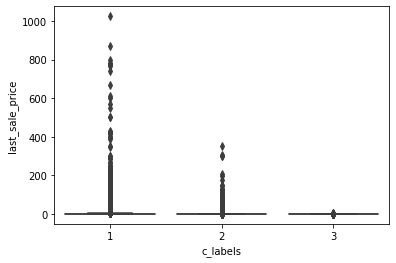

In [ ]:
sns.boxplot(x='c_labels', y=TARGET, data=train);

There's an ordinal structure in the sale price of NFTs in each cluster. Here, collections in cluster 3 have lower sale price.

In [ ]:
train[TARGET].describe()

count    3.099100e+05
mean     2.162269e+00
std      1.275132e+01
min      6.485360e-08
25%      4.077085e-03
50%      8.103344e-03
75%      3.252062e-01
max      1.024002e+03
Name: last_sale_price, dtype: float64

In [ ]:
train['labels'] = (train[TARGET] > train[TARGET].median()).astype(int)

In [ ]:
train.labels.value_counts(True)

1    0.5
0    0.5
Name: labels, dtype: float64

In [ ]:
train.shape, test.shape

((309910, 44), (181214, 42))

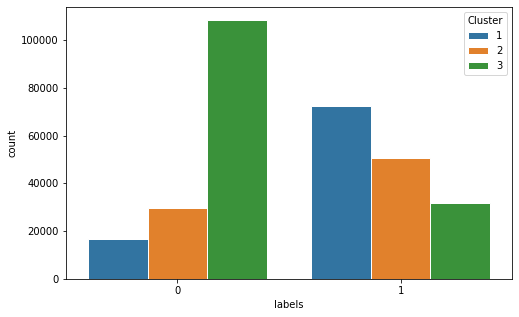

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot(x='labels', hue='c_labels', data=train, edgecolor='white')
plt.legend(title='Cluster');

This mirrors the boxplot above. Many of NFTs in cluster 3 have sale prices below the median sale price

In [ ]:
# one-hot encoding cluster labels
train = pd.get_dummies(train, columns=['c_labels'])
test = pd.get_dummies(test, columns=['c_labels'])

In [ ]:
remove_cols = ['global_index', 'nft_id', 'collection_id', 'last_sale_date', 'creation_date', TARGET, 'labels']

In [ ]:
X = train.drop(columns=remove_cols)
y = train['labels']

In [ ]:
X.head()

,rarity_score,openrarity_score,openrarity_rank,openrarity_max_rank,total_supply,verification_status,n_of_traits,contract_type,seller_fees,openrarity_enabled,has_discord,has_medium,age,n_tweets_in_range,avg_likes,avg_replies,avg_retweets,min_likes,min_replies,min_retweets,max_likes,max_replies,max_retweets,col_age_at_sale,sale_month,sale_quarter,sale_year,coll_targ_min,coll_targ_mean,coll_targ_max,coll_targ_std,n_nft_in_sdate,col_min_last_sale_price,col_mean_last_sale_price,col_max_last_sale_price,col_std_last_sale_price,c_labels_1,c_labels_2,c_labels_3
0,2.000000,NaN,NaN,NaN,1,1,2,1,1000.0,0,1,0,9.002238,31,187.967742,8.290323,60.935484,0,0,2,591,28,380,7.030945,11,4,2022,1.266732,1.266732,1.266732,NaN,1,1.266732,1.266732,1.266732,NaN,1,0,0
1,97.077216,NaN,NaN,NaN,8888,1,5,1,500.0,0,1,0,18.004476,11,133.181818,13.454545,55.181818,0,0,7,402,47,239,1.018501,8,3,2021,0.000037,2.559610,400.001379,5.344588,3143,0.000182,2.662060,130.005079,4.641399,1,0,0
2,139.453086,NaN,NaN,NaN,8888,1,5,1,500.0,0,1,0,18.004476,11,133.181818,13.454545,55.181818,0,0,7,402,47,239,13.010534,8,3,2022,0.000037,2.559610,400.001379,5.344588,750,0.000064,4.059408,400.001379,14.646178,1,0,0
3,127.753445,NaN,NaN,NaN,8888,1,5,1,500.0,0,1,0,18.004476,11,133.181818,13.454545,55.181818,0,0,7,402,47,239,1.018501,8,3,2021,0.000037,2.559610,400.001379,5.344588,3143,0.000182,2.662060,130.005079,4.641399,1,0,0
4,112.315719,NaN,NaN,NaN,8888,1,5,1,500.0,0,1,0,18.004476,11,133.181818,13.454545,55.181818,0,0,7,402,47,239,14.029036,9,3,2022,0.000037,2.559610,400.001379,5.344588,276,0.000441,3.782424,24.005621,1.869985,1,0,0


In [ ]:
# splitting into train and validation data
xtrain, xval, ytrain, yval = train_test_split(X, y, random_state=0)

In [ ]:
xtrain.shape, xval.shape

((232432, 39), (77478, 39))

__Classification Model__

In [ ]:
def metric(clf, x, y):
  ypred = clf.predict(x)
  proba = clf.predict_proba(x)[:,1]
  acc = accuracy_score(y, ypred)
  auc = roc_auc_score(y, proba)
  print(f'Accuracy: {acc:.5f}\tAUC: {auc:.5f}')

In [ ]:
lgbm = lgb.LGBMClassifier(n_estimators=1500,subsample=0.6, colsample_bytree=0.5, 
                          learning_rate=0.05,random_state=0, importance_type='gain')

In [ ]:
lgbm.fit(xtrain, ytrain);

In [ ]:
# Train
metric(lgbm, xtrain, ytrain)

Accuracy: 0.78288	AUC: 0.84133


In [ ]:
# Validation
metric(lgbm, xval, yval)

Accuracy: 0.76986	AUC: 0.82204


__Important Features__

In [ ]:
imp = pd.Series(lgbm.feature_importances_, index=xtrain.columns).sort_values(ascending=False)
imp = imp/imp.sum()

In [ ]:
imp

col_mean_last_sale_price    0.301451
coll_targ_mean              0.146372
coll_targ_min               0.087014
contract_type               0.083048
c_labels_3                  0.069925
coll_targ_std               0.051743
avg_retweets                0.037049
rarity_score                0.031954
openrarity_max_rank         0.026513
n_tweets_in_range           0.016407
openrarity_score            0.015316
openrarity_rank             0.014514
total_supply                0.014300
max_retweets                0.010619
col_age_at_sale             0.009968
col_min_last_sale_price     0.009508
n_nft_in_sdate              0.009145
col_std_last_sale_price     0.008504
col_max_last_sale_price     0.008057
n_of_traits                 0.007553
age                         0.006279
sale_month                  0.005736
max_likes                   0.004838
seller_fees                 0.004283
coll_targ_max               0.003348
min_replies                 0.002673
avg_likes                   0.002584
m

In [ ]:
confusion_matrix(ytrain, lgbm.predict(xtrain))

array([[94402, 21643],
       [28823, 87564]])

In [ ]:
confusion_matrix(yval, lgbm.predict(xval))

array([[31063,  7847],
       [ 9984, 28584]])

Prediction

In [ ]:
# probability that NFT will have last sale price above the median value
train['targ_proba'] = lgbm.predict_proba(train[xtrain.columns])[:,1]
test['targ_proba'] = lgbm.predict_proba(test[xtrain.columns])[:,1]

In [ ]:
# remove labels from train
train = train.drop('labels', axis=1)

In [ ]:
train.shape, test.shape

((309910, 46), (181214, 45))

In [ ]:
# saving data sets
train.to_parquet('data/train_cleaned.parquet', index=False)
test.to_parquet('data/test_cleaned.parquet', index=False)

In [ ]:
train.head()

,global_index,nft_id,collection_id,rarity_score,openrarity_score,openrarity_rank,openrarity_max_rank,last_sale_date,last_sale_price,total_supply,creation_date,verification_status,n_of_traits,contract_type,seller_fees,openrarity_enabled,has_discord,has_medium,age,n_tweets_in_range,avg_likes,avg_replies,avg_retweets,min_likes,min_replies,min_retweets,max_likes,max_replies,max_retweets,col_age_at_sale,sale_month,sale_quarter,sale_year,coll_targ_min,coll_targ_mean,coll_targ_max,coll_targ_std,n_nft_in_sdate,col_min_last_sale_price,col_mean_last_sale_price,col_max_last_sale_price,col_std_last_sale_price,c_labels_1,c_labels_2,c_labels_3,targ_proba
0,21928,0,49,2.000000,NaN,NaN,NaN,2022-11-01,1.266732,1,2022-04-01,1,2,1,1000.0,0,1,0,9.002238,31,187.967742,8.290323,60.935484,0,0,2,591,28,380,7.030945,11,4,2022,1.266732,1.266732,1.266732,NaN,1,1.266732,1.266732,1.266732,NaN,1,0,0,0.968786
1,32621,0,45,97.077216,NaN,NaN,NaN,2021-08-01,1.200357,8888,2021-07-01,1,5,1,500.0,0,1,0,18.004476,11,133.181818,13.454545,55.181818,0,0,7,402,47,239,1.018501,8,3,2021,0.000037,2.559610,400.001379,5.344588,3143,0.000182,2.662060,130.005079,4.641399,1,0,0,0.982246
2,32622,1,45,139.453086,NaN,NaN,NaN,2022-08-01,3.180572,8888,2021-07-01,1,5,1,500.0,0,1,0,18.004476,11,133.181818,13.454545,55.181818,0,0,7,402,47,239,13.010534,8,3,2022,0.000037,2.559610,400.001379,5.344588,750,0.000064,4.059408,400.001379,14.646178,1,0,0,0.987769
3,32623,2,45,127.753445,NaN,NaN,NaN,2021-08-01,3.502910,8888,2021-07-01,1,5,1,500.0,0,1,0,18.004476,11,133.181818,13.454545,55.181818,0,0,7,402,47,239,1.018501,8,3,2021,0.000037,2.559610,400.001379,5.344588,3143,0.000182,2.662060,130.005079,4.641399,1,0,0,0.978075
4,32624,3,45,112.315719,NaN,NaN,NaN,2022-09-01,4.009567,8888,2021-07-01,1,5,1,500.0,0,1,0,18.004476,11,133.181818,13.454545,55.181818,0,0,7,402,47,239,14.029036,9,3,2022,0.000037,2.559610,400.001379,5.344588,276,0.000441,3.782424,24.005621,1.869985,1,0,0,0.971822
